In [ ]:
################################################
# Otimização de hiperparâmetros para o GRU
################################################

In [ ]:
!pip install neuralforecast
!pip install feature-engine

In [ ]:
import os
import sys
import math
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoGRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
from neuralforecast.losses.numpy import mase as mase_numpy
from utilsforecast.losses import mase
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
import sklearn
import neuralforecast
import feature_engine

In [ ]:
# Versões
print('Versões:')
print('Python: %s' % sys.version)
print('Pandas: %s' % pd.__version__)
print('Numpy: %s' % np.__version__)
print('Sklearn: %s' % sklearn.__version__)
print('NeuralForecast: %s' % neuralforecast.__version__)
print('Feature-Engine: %s' % feature_engine.__version__)

Versões:
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Sklearn: 1.6.1
NeuralForecast: 3.0.2
Feature-Engine: 1.8.3


In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"

FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
SEED = 78

horizon = 187
input_size = 187

In [ ]:
train = pd.read_csv(f"{ROOT}/data/train_data_scaled.csv")
test = pd.read_csv(f"{ROOT}/data/test_data_scaled.csv")

In [ ]:
# Requrimento do nixtla
train['unique_id'] = 'slug_flow'
train['ds'] = train['time']
train['y'] = train['liquid_flow_rate']


test['unique_id'] = 'slug_flow'
test['ds'] = test['time']
test['y'] = test['liquid_flow_rate']

In [ ]:
gru_config = AutoGRU.get_default_config(h = horizon, backend="ray")
gru_config.update(
    {
        'input_size': input_size,
        'exclude_insample_y': True,
        'hist_exog_list': FEATURES,
        'early_stop_patience_steps': 10,
        'val_check_steps': 100,
        'random_seed': SEED
    }
)
gru_config

{'h': None,
 'encoder_hidden_size': <ray.tune.search.sample.Categorical at 0x7f9f17b79710>,
 'encoder_n_layers': <ray.tune.search.sample.Integer at 0x7f9ea258c950>,
 'context_size': <ray.tune.search.sample.Categorical at 0x7f9e92bfc250>,
 'decoder_hidden_size': <ray.tune.search.sample.Categorical at 0x7f9e92bfe990>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7f9e8af11110>,
 'max_steps': <ray.tune.search.sample.Categorical at 0x7f9e8af136d0>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7f9e920fc110>,
 'loss': None,
 'random_seed': 78,
 'input_size': 187,
 'inference_input_size': <ray.tune.search.sample.Categorical at 0x7f9e2bf99490>,
 'exclude_insample_y': True,
 'hist_exog_list': ['pressure_1',
  'pressure_2',
  'pressure_3',
  'pressure_4',
  'pressure_5',
  'pressure_6',
  'pressure_7'],
 'early_stop_patience_steps': 10,
 'val_check_steps': 100}

### Training

In [ ]:
models = [
    AutoGRU(
        h=horizon,
        loss=MAE(),
        config=gru_config,
        search_alg=HyperOptSearch(),
        backend='ray',
        num_samples=30
    )
]

In [ ]:
nf = NeuralForecast(
    models=models,
    freq=1
)
nf.fit(
    df=train, val_size=horizon
)

In [ ]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train.tail(input_size), test])

In [ ]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
forecasts_list = []
for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

In [ ]:
forecasts_output = pd.concat(forecasts_list)
forecasts_output

,unique_id,ds,AutoGRU
0,slug_flow,1501,0.425353
1,slug_flow,1502,0.480305
2,slug_flow,1503,0.480836
3,slug_flow,1504,0.487708
4,slug_flow,1505,0.497203
...,...,...,...
182,slug_flow,3179,0.277031
183,slug_flow,3180,0.277081
184,slug_flow,3181,0.277137
185,slug_flow,3182,0.277182


In [ ]:
ground_truth = test[['unique_id', 'ds', 'y']]
ground_truth

,unique_id,ds,y
0,slug_flow,1501,0.459397
1,slug_flow,1502,0.471283
2,slug_flow,1503,0.484231
3,slug_flow,1504,0.496564
4,slug_flow,1505,0.510421
...,...,...,...
1495,slug_flow,2996,0.279759
1496,slug_flow,2997,0.279714
1497,slug_flow,2998,0.279125
1498,slug_flow,2999,0.278436


In [ ]:
exogenous_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)

exogenous_results

,unique_id,ds,y,AutoGRU
0,slug_flow,1501,0.459397,0.425353
1,slug_flow,1502,0.471283,0.480305
2,slug_flow,1503,0.484231,0.480836
3,slug_flow,1504,0.496564,0.487708
4,slug_flow,1505,0.510421,0.497203
...,...,...,...,...
1495,slug_flow,2996,0.279759,0.279876
1496,slug_flow,2997,0.279714,0.278823
1497,slug_flow,2998,0.279125,0.278589
1498,slug_flow,2999,0.278436,0.278412


In [ ]:
file_name = "gru_bayesopt"
version = "v1"
exogenous_results.to_csv(f"{ROOT}/results/{file_name}_{version}.csv", index=False, mode='x')

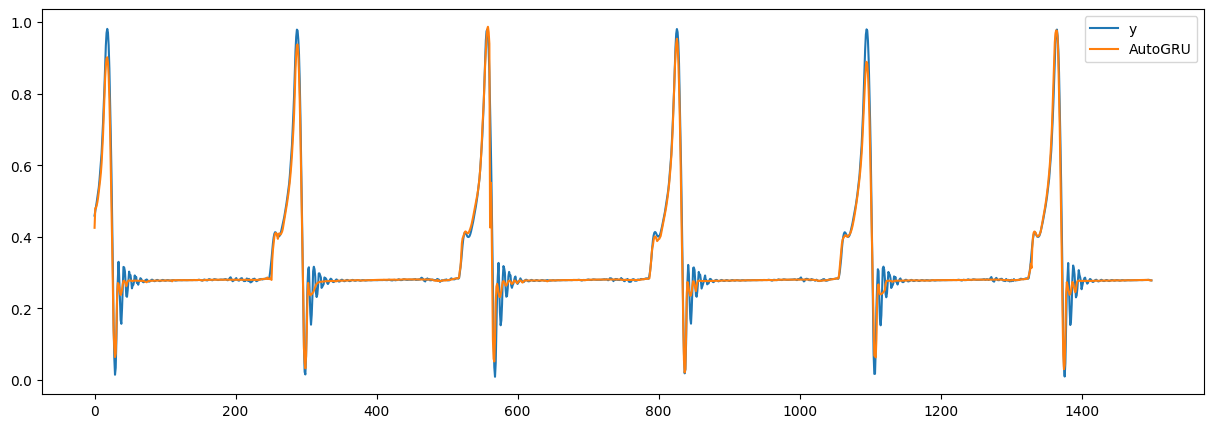

In [ ]:
exogenous_results[['y', 'AutoGRU']].plot(figsize=(15, 5));

In [ ]:
##########################################
# Espaço de busca da otimizaçao bayseana
##########################################

from ray.tune.search.sample import Categorical, Float, Integer, Domain

# Get the config dictionary with the Ray Tune sampler objects
config = AutoGRU.get_default_config(h=horizon, backend='ray')

print("Inspecting the AutoGRU Default Search Space Programmatically:\n")

def describe_sampler(sampler):
    """Helper function to describe different sampler types"""
    if isinstance(sampler, Categorical):
        return f"Categorical Choice\n  -> Values: {sampler.categories}"
    elif isinstance(sampler, Float):
        # For Float samplers, check if it's loguniform by looking at the base
        if getattr(sampler, 'base', None) == 10:  # LogUniform has base=10
            return f"Log-Uniform Float\n  -> Range: [{sampler.lower}, {sampler.upper}]"
        else:
            return f"Uniform Float\n  -> Range: [{sampler.lower}, {sampler.upper}]"
    elif isinstance(sampler, Integer):
        return f"Uniform Integer\n  -> Range: [{sampler.lower}, {sampler.upper}]"
    elif isinstance(sampler, Domain):
        return f"Domain Sampler\n  -> Type: {type(sampler).__name__}"
    else:
        return f"Fixed Value\n  -> Value: {sampler}"

# Iterate through the hyperparameters and their sampler objects
for param, sampler in config.items():
    print(f"Hyperparameter: '{param}'")
    print(f"  -> Type: {describe_sampler(sampler)}\n")

Inspecting the AutoGRU Default Search Space Programmatically:

Hyperparameter: 'h'
  -> Type: Fixed Value
  -> Value: None

Hyperparameter: 'encoder_hidden_size'
  -> Type: Categorical Choice
  -> Values: [16, 32, 64, 128]

Hyperparameter: 'encoder_n_layers'
  -> Type: Uniform Integer
  -> Range: [1, 4]

Hyperparameter: 'context_size'
  -> Type: Categorical Choice
  -> Values: [5, 10, 50]

Hyperparameter: 'decoder_hidden_size'
  -> Type: Categorical Choice
  -> Values: [16, 32, 64, 128]

Hyperparameter: 'learning_rate'
  -> Type: Uniform Float
  -> Range: [0.0001, 0.1]

Hyperparameter: 'max_steps'
  -> Type: Categorical Choice
  -> Values: [500, 1000]

Hyperparameter: 'batch_size'
  -> Type: Categorical Choice
  -> Values: [16, 32]

Hyperparameter: 'loss'
  -> Type: Fixed Value
  -> Value: None

Hyperparameter: 'random_seed'
  -> Type: Uniform Integer
  -> Range: [1, 20]

Hyperparameter: 'input_size'
  -> Type: Categorical Choice
  -> Values: [-187, 748, 2992, 11968]

Hyperparameter: '

In [ ]:
####################################################
# Salvar os parametros de cada etapa da otimizaçao.
####################################################

pd.set_option('display.max_columns', None)
bayesopt_logs = nf.models[0].results.get_dataframe()
bayesopt_logs.to_csv(f"{ROOT}/results/{file_name}_bayesopt_logs-{version}.csv", index=False, mode='x')

# bayesopt_logs

In [ ]:
########################################
# Pegar os hiper-parâmetros selecionados
########################################

(
    bayesopt_logs
    .loc[
        bayesopt_logs['loss'] == bayesopt_logs['loss'].min(), [column for column in bayesopt_logs.columns if column.startswith("config/")]
    ]
    .rename(columns={column: column.replace('config/', '') for column in bayesopt_logs.columns})
    .to_dict(orient='records')
)

[{'h': 187,
  'encoder_hidden_size': 128,
  'encoder_n_layers': 2,
  'context_size': 10,
  'decoder_hidden_size': 16,
  'learning_rate': 0.005155753290809891,
  'max_steps': 500,
  'batch_size': 16,
  'loss': MAE(),
  'random_seed': 78,
  'input_size': 187,
  'inference_input_size': -187,
  'exclude_insample_y': True,
  'hist_exog_list': ('pressure_1',
   'pressure_2',
   'pressure_3',
   'pressure_4',
   'pressure_5',
   'pressure_6',
   'pressure_7'),
  'early_stop_patience_steps': 10,
  'val_check_steps': 100,
  'valid_loss': MAE()}]

In [ ]:
# Salvar modelo
import os
model_dir = f"{ROOT}/models/{file_name}_BayesOptGRU{version}/"
os.makedirs(model_dir, exist_ok=True)
nf.save(path=model_dir)

### Performance

In [ ]:
import joblib
import pandas as pd

In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"
file_name = "gru_bayesopt"
version = "v1"
gru_results = pd.read_csv(f"{ROOT}/results/{file_name}_{version}.csv")

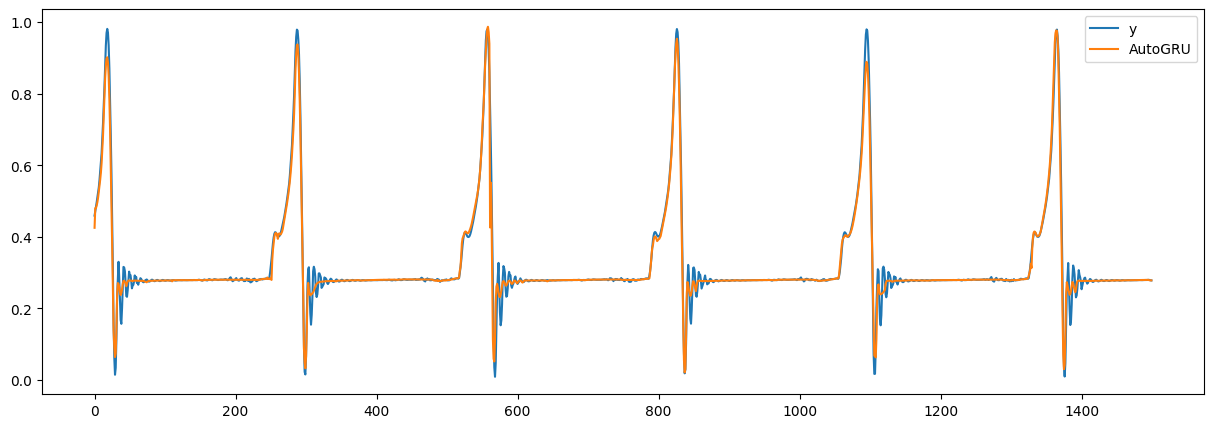

In [ ]:
gru_results[['y', 'AutoGRU']].plot(figsize=(15, 5));

In [ ]:
scaler = joblib.load(f"{ROOT}/data/scaler.joblib")

In [ ]:
############
# Métricas
############

In [ ]:
##################################
# Retornar para a escala original
##################################

n_rows = len(gru_results)
dummy_df = pd.DataFrame(
    data={
        'pressure_1': [0]*n_rows,
        'pressure_2': [0]*n_rows,
        'pressure_3': [0]*n_rows,
        'pressure_4': [0]*n_rows,
        'pressure_5': [0]*n_rows,
        'pressure_6': [0]*n_rows,
        'pressure_7': [0]*n_rows,
        'gas_flow_rate': [0]*n_rows,
        'liquid_flow_rate': [0]*n_rows
    }
)

model_outputs_columns = [
    'y', # y_true
    'AutoGRU'
]


original_scale_predictons = {}
for column in model_outputs_columns:
    dummy_df['liquid_flow_rate'] = gru_results[column]
    reverse_df = scaler.inverse_transform(dummy_df)
    original_scale_predictons[column] = reverse_df['liquid_flow_rate']


original_scale_df = pd.concat(
    [
        gru_results[['unique_id', 'ds']],
        pd.DataFrame(original_scale_predictons)
    ],
    axis=1
)

original_scale_df

,unique_id,ds,y,AutoGRU
0,slug_flow,1501,91.592333,78.538810
1,slug_flow,1502,96.149750,99.609363
2,slug_flow,1503,101.114667,99.812748
3,slug_flow,1504,105.843333,102.447887
4,slug_flow,1505,111.156667,106.088458
...,...,...,...,...
1495,slug_flow,2996,22.713000,22.758097
1496,slug_flow,2997,22.696038,22.354410
1497,slug_flow,2998,22.470111,22.264590
1498,slug_flow,2999,22.205667,22.196711


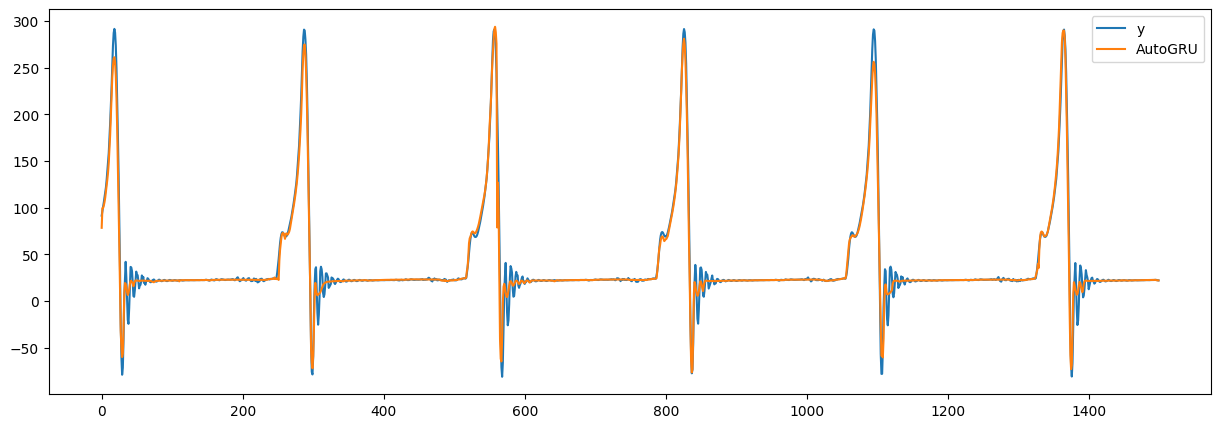

In [ ]:
original_scale_df[['y', 'AutoGRU']].plot(figsize=(15, 5));

In [ ]:
y_true = original_scale_df['y']
y_pred = original_scale_df['AutoGRU']

In [ ]:
print(f"RMSE: {math.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

RMSE: 8.761216313411119
MAE: 3.5142375103280017
